# Importation des librairies

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from PIL import ImageFile

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling2D,
    Input
)

# Configuration et Téléchargement des Données

In [2]:
print("GPU Disponible : ", len(tf.config.list_physical_devices('GPU')) > 0)

if not os.path.exists('kaggle.json'):
    print("Veuillez uploader votre fichier kaggle.json :")
    files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Téléchargement du dataset (cela peut prendre 1-2 minutes)...")
!kaggle datasets download -d abdelghaniaaba/wildfire-prediction-dataset
!unzip -q wildfire-prediction-dataset.zip
print("Extraction terminée.")

base_dir = os.getcwd()
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
valid_dir = os.path.join(base_dir, 'valid')

print(f"Dossiers détectés : {os.listdir(base_dir)}")

GPU Disponible :  True
Veuillez uploader votre fichier kaggle.json :


Saving kaggle.json to kaggle.json
Téléchargement du dataset (cela peut prendre 1-2 minutes)...
Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset
License(s): other
 99% 1.43G/1.45G [00:15<00:00, 152MB/s]
100% 1.45G/1.45G [00:15<00:00, 98.9MB/s]
Extraction terminée.
Dossiers détectés : ['.config', 'train', 'valid', 'kaggle.json', 'wildfire-prediction-dataset.zip', 'test', 'sample_data']


# Analyse Exploratoire

Distribution du set d'entraînement : {'wildfire': 15750, 'nowildfire': 14500}


/tmp/ipython-input-1537307058.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), palette=['firebrick', 'forestgreen'])


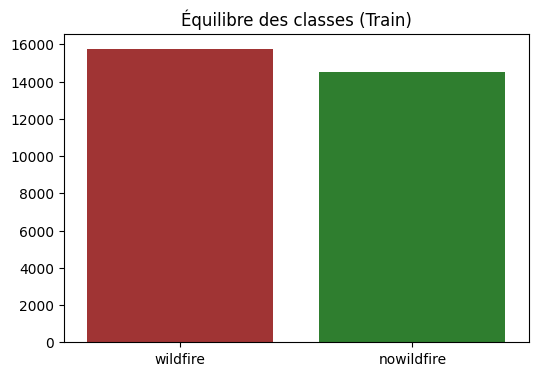

Affichage d'échantillons aléatoires :


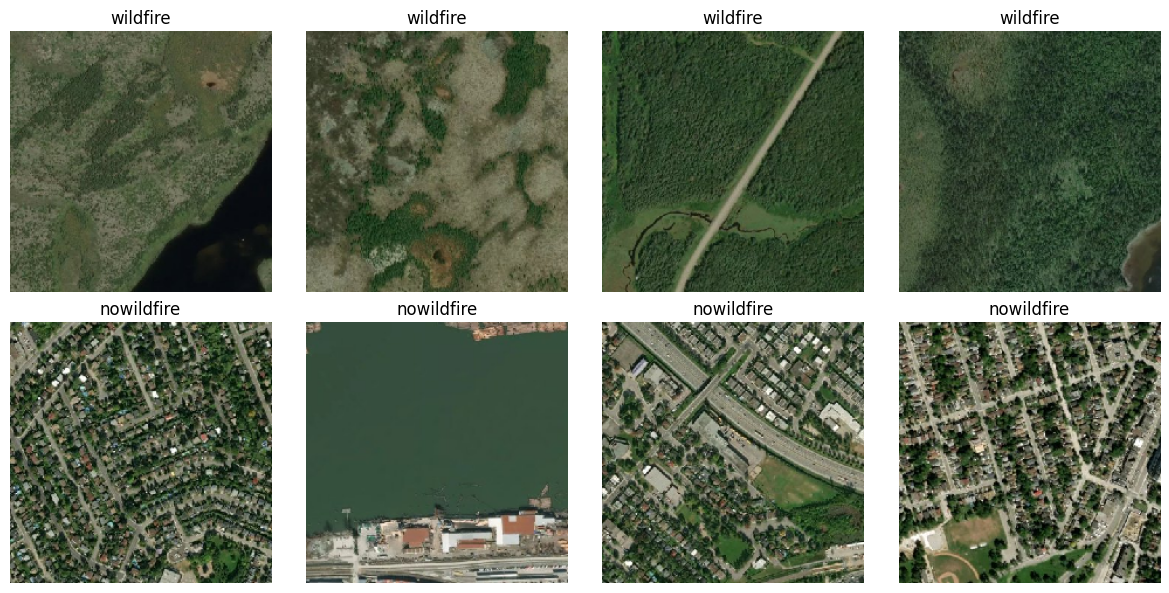

In [3]:
def count_images(directory):
    classes = ['wildfire', 'nowildfire']
    counts = {}
    for c in classes:
        path = os.path.join(directory, c)
        counts[c] = len(os.listdir(path))
    return counts

train_counts = count_images(train_dir)
print("Distribution du set d'entraînement :", train_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), palette=['firebrick', 'forestgreen'])
plt.title("Équilibre des classes (Train)")
plt.show()


def show_sample_images(directory):
    plt.figure(figsize=(12, 6))
    classes = ['wildfire', 'nowildfire']

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        img_files = np.random.choice(os.listdir(class_dir), 4, replace=False)

        for j, img_file in enumerate(img_files):
            img_path = os.path.join(class_dir, img_file)
            img = image.load_img(img_path, target_size=(224, 224))

            plt.subplot(2, 4, i * 4 + j + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Affichage d'échantillons aléatoires :")
show_sample_images(train_dir)

# Prétraitement et Data Augmentation

In [4]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

print("Loading Train Data...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print("Loading Validation Data...")
validation_generator = val_test_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Loading Test Data...")
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Loading Train Data...
Found 30250 images belonging to 2 classes.
Loading Validation Data...
Found 6300 images belonging to 2 classes.
Loading Test Data...
Found 6300 images belonging to 2 classes.


# Définition d'architectures

In [5]:
def create_fast_cnn():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dropout(0.2))

    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = create_fast_cnn()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,146 (16.08 MB)

 Trainable params: 4,214,018 (16.08 MB)

 Non-trainable params: 128 (512.00 B)

# Entraînement de modèles

In [6]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

print("Starting Training...")
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)


Starting Training...
Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


946/946 ━━━━━━━━━━━━━━━━━━━━ 97s 96ms/step - accuracy: 0.8911 - loss: 0.6030 - val_accuracy: 0.8943 - val_loss: 0.2389
Epoch 2/25
946/946 ━━━━━━━━━━━━━━━━━━━━ 89s 94ms/step - accuracy: 0.9190 - loss: 0.2058 - val_accuracy: 0.9146 - val_loss: 0.2273
Epoch 3/25
946/946 ━━━━━━━━━━━━━━━━━━━━ 83s 88ms/step - accuracy: 0.9313 - loss: 0.1841 - val_accuracy: 0.9406 - val_loss: 0.1746
Epoch 4/25
946/946 ━━━━━━━━━━━━━━━━━━━━ 84s 89ms/step - accuracy: 0.9334 - loss: 0.1723 - val_accuracy: 0.9400 - val_loss: 0.1608
Epoch 5/25
946/946 ━━━━━━━━━━━━━━━━━━━━ 142s 89ms/step - accuracy: 0.9357 - loss: 0.1662 - val_accuracy: 0.9156 - val_loss: 0.2091
Epoch 6/25
946/946 ━━━━━━━━━━━━━━━━━━━━ 84s 89ms/step - accuracy: 0.9352 - loss: 0.1715 - val_accuracy: 0.9079 - val_loss: 0.2665
Epoch 7/25
946/946 ━━━━━━━━━━━━━━━━━━━━ 143s 90ms/step - accuracy: 0.9409 - loss: 0.1595 - val_accuracy: 0.9379 - val_loss: 0.1663
Epoch 8/25
946/946 ━━━━━━━━━━━━━━━━━━━━ 84s 89ms/step - accuracy: 0.9435 - loss: 0.1501 - val_accur

# Visualisation / Sauvgarde

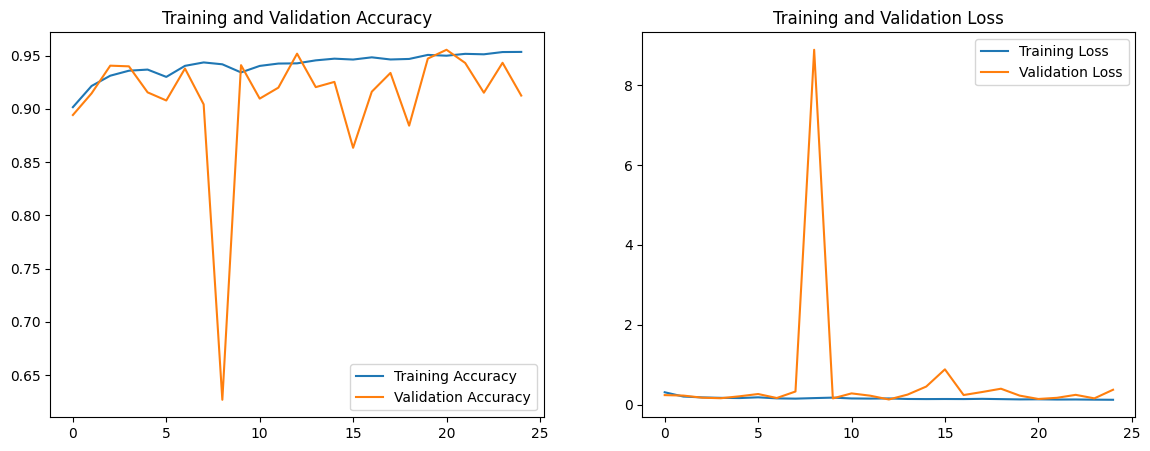

Evaluating on Test Set...
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9503 - loss: 0.2810


Test Accuracy: 91.92%
Model saved as wildfire_model_64x64.h5


In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print("Evaluating on Test Set...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")

model.save('wildfire_model_64x64.h5')
print("Model saved as wildfire_model_64x64.h5")